### Questions - what are the additive terms? 

How to improve model performance??? 

Making the input daily? 

In [282]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
logging.getLogger().setLevel(logging.ERROR)


In [283]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [284]:
LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)

#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

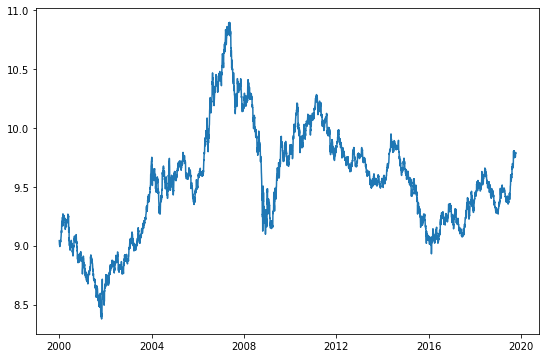

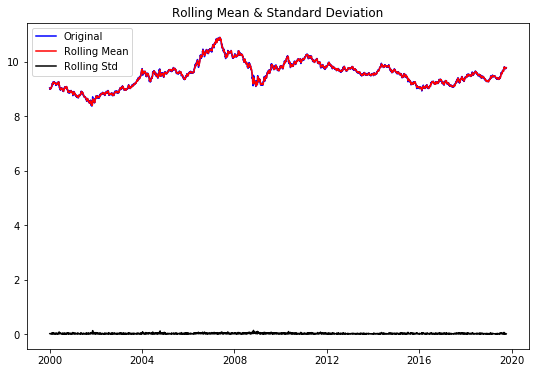

Results of Dickey-Fuller Test:
Test Statistic                   -1.869969
p-value                           0.346318
#Lags Used                        0.000000
Number of Observations Used    5155.000000
Critical Value (1%)              -3.431619
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


In [285]:

LME = LME.resample('B').mean()
LME_log = np.log(LME)
rcParams['figure.figsize'] = 9, 6

plt.plot(LME_log)
plt.show()
test_stationarity(LME_log)

In [286]:
#preprocess_comp  = pd.DataFrame({'original':LME_log, 'means by 4': moving_avg.shift(), 'moving diff': moving_diff})

#preprocess_comp.head()


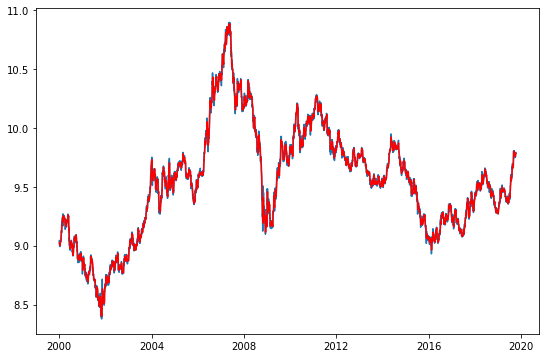

<class 'pandas.core.series.Series'>


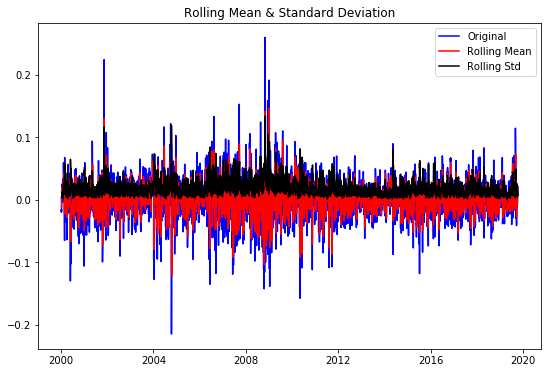

Results of Dickey-Fuller Test:
Test Statistic                  -25.760302
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    5146.000000
Critical Value (1%)              -3.431621
Critical Value (5%)              -2.862102
Critical Value (10%)             -2.567069
dtype: float64


In [287]:
window_setting=4
moving_avg = LME_log.rolling(window=window_setting).mean()
plt.plot(LME_log)
plt.plot(moving_avg, color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()

moving_diff = LME_log-moving_avg.shift()
moving_diff = moving_diff.dropna()
#moving_diff = moving_diff.to_frame()
print(type(moving_diff))
test_stationarity(moving_diff)

In [288]:
LME_log.head()

Unnamed: 1
2000-01-03    9.043104
2000-01-04    9.023408
2000-01-05    9.022685
2000-01-06    9.016574
2000-01-07    9.007245
Freq: B, Name: Cash Price ($/MT), dtype: float64

## Modeling

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



### TRAINING AND TESTING MODEL PROCEDURES

Use prophet to autobuild models that are trained to test 17 years back to predict for one year ahead
and RECORD RESULTS

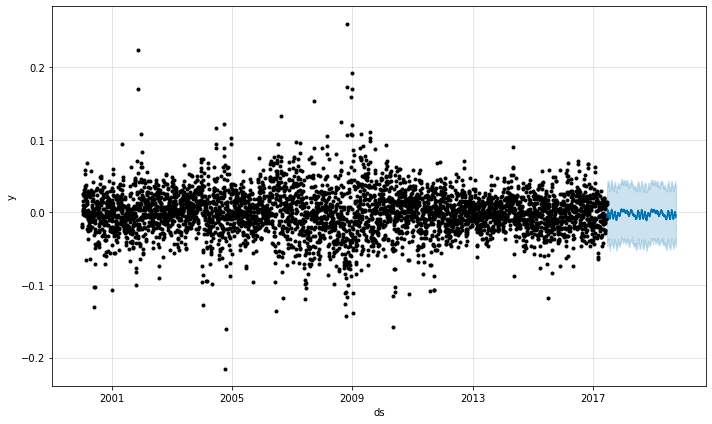

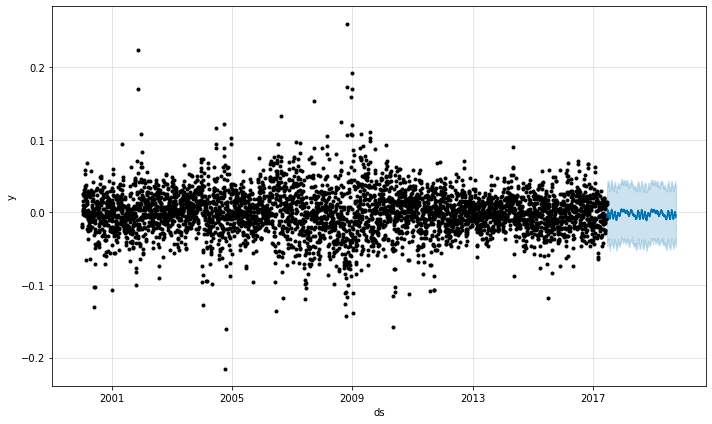

In [289]:
list_one = list(moving_diff.index)
list_two = list(moving_diff)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'y'])
moving_diff

# pred size = 2 years
prediction_size = 400

# gap size for 1 year missing
gap_size = 200
train_df = df[:-prediction_size-gap_size]

m = Prophet()
m.fit(train_df)

test_df = df[-prediction_size-gap_size:]
forecast = m.predict(test_df)
m.plot(forecast)



In [290]:
forecast.index = forecast['ds']
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
2017-06-20,2017-06-20,-0.004980,-0.043733,0.032526,-0.004980,-0.004980,-0.001932,-0.001932,-0.001932,0.002529,0.002529,0.002529,-0.004461,-0.004461,-0.004461,0.0,0.0,0.0,-0.006911
2017-06-21,2017-06-21,-0.004980,-0.046842,0.034874,-0.004980,-0.004980,-0.001217,-0.001217,-0.001217,0.002640,0.002640,0.002640,-0.003857,-0.003857,-0.003857,0.0,0.0,0.0,-0.006197
2017-06-22,2017-06-22,-0.004981,-0.044504,0.036408,-0.004981,-0.004981,-0.000881,-0.000881,-0.000881,0.002323,0.002323,0.002323,-0.003204,-0.003204,-0.003204,0.0,0.0,0.0,-0.005862
2017-06-23,2017-06-23,-0.004982,-0.043988,0.035898,-0.004982,-0.004982,0.001643,0.001643,0.001643,0.004155,0.004155,0.004155,-0.002512,-0.002512,-0.002512,0.0,0.0,0.0,-0.003339
2017-06-26,2017-06-26,-0.004984,-0.039567,0.039433,-0.004984,-0.004984,0.002532,0.002532,0.002532,0.002863,0.002863,0.002863,-0.000330,-0.000330,-0.000330,0.0,0.0,0.0,-0.002452


## Modeling the Moving Average!! 

- Will start at the end of the training data and is used ONLY TO FILL IN THE SPACE between the evaluated values and the training data 


In [291]:
# forecast['yhat'].rolling(window=4).mean()
LME_log_train = LME_log[:-prediction_size-gap_size:]

original_tail = LME_log_train.rolling(window=window_setting).mean().tail(window_setting)
original_tail
#moving_avg = LME_log.rolling(window=4).mean()



Unnamed: 1
2017-06-14    9.084760
2017-06-15    9.080977
2017-06-16    9.085156
2017-06-19    9.091205
Freq: B, Name: Cash Price ($/MT), dtype: float64

In [292]:
'''Rescaling predicted values back to scale using rolling mean'''

results = []

ys_for_avgs = original_tail.to_dict()

'''Identify date in KEY, predicted value in ITEM'''
for key, item in forecast['yhat'].items():
    
    '''Manually calculate sum'''
    rolling_avg = 0
    for i in range(window_setting):
        time_frame_ref = key +datetime.timedelta(weeks=-i-1)
        '''look up time_frame_ref in dictionary'''
        rolling_avg = rolling_avg + ys_for_avgs[time_frame_ref]
    print('resulting avg: ', rolling_avg/window_setting)
    
    #singular_avg = 
    scaled = item + rolling_avg/window_setting
    results.append(scaled)
    ys_for_avgs[key] = scaled
    

KeyError: Timestamp('2017-06-13 00:00:00')

In [293]:
forecast['scaled_yhat'] = results

ValueError: Length of values does not match length of index

In [281]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,scaled_yhat
ds,,,,,,,,,,,,,,,,,
2008-04-20,2008-04-20,0.012786,-0.060754,0.113742,0.012786,0.012786,0.009403,0.009403,0.009403,0.009403,0.009403,0.009403,0.0,0.0,0.0,0.022189,10.335807
2008-04-27,2008-04-27,0.012811,-0.062400,0.105246,0.012811,0.012811,0.007818,0.007818,0.007818,0.007818,0.007818,0.007818,0.0,0.0,0.0,0.020629,10.334589
2008-05-04,2008-05-04,0.012836,-0.065996,0.101356,0.012836,0.012836,0.004555,0.004555,0.004555,0.004555,0.004555,0.004555,0.0,0.0,0.0,0.017391,10.330687
2008-05-11,2008-05-11,0.012862,-0.062645,0.104320,0.012862,0.012862,0.007359,0.007359,0.007359,0.007359,0.007359,0.007359,0.0,0.0,0.0,0.020220,10.340061
2008-05-18,2008-05-18,0.012887,-0.048312,0.114254,0.012887,0.012887,0.017804,0.017804,0.017804,0.017804,0.017804,0.017804,0.0,0.0,0.0,0.030691,10.365977
2008-05-25,2008-05-25,0.012912,-0.039742,0.119519,0.012912,0.012912,0.026766,0.026766,0.026766,0.026766,0.026766,0.026766,0.0,0.0,0.0,0.039678,10.382507
2008-06-01,2008-06-01,0.012937,-0.056114,0.118488,0.012937,0.012938,0.020299,0.020299,0.020299,0.020299,0.020299,0.020299,0.0,0.0,0.0,0.033236,10.388044
2008-06-08,2008-06-08,0.012963,-0.076246,0.092885,0.012963,0.012963,-0.006929,-0.006929,-0.006929,-0.006929,-0.006929,-0.006929,0.0,0.0,0.0,0.006033,10.375180
2008-06-15,2008-06-15,0.012988,-0.110134,0.053041,0.012988,0.012988,-0.042468,-0.042468,-0.042468,-0.042468,-0.042468,-0.042468,0.0,0.0,0.0,-0.029480,10.348447


## Back to Scale before Performance Analysis

In [294]:
test_forecast = forecast.iloc[-prediction_size:,:]


test_start_date = test_forecast.index[0]

yhat = test_forecast['yhat']

y = moving_diff[test_start_date:]
#shifted_by_avg = moving_avg[test_start_date:]

scaled_yhat = test_forecast['scaled_yhat'] 

#scaled_y =  moving_diff[test_start_date:] + moving_avg[test_start_date:]
#scaled_y = 

actual_y = LME_log[test_start_date:]


KeyError: 'scaled_yhat'

In [241]:
'''
y = moving_diff['2018-05-15':]
shifted_by_avg = moving_avg['2018-05-15':]


scaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]
scaled_yhat

scaled_y =  moving_diff['2018-05-15':] + moving_avg['2018-05-15':]
scaled_y

actual_y = LME_log['2018-05-15':]
'''

"\ny = moving_diff['2018-05-15':]\nshifted_by_avg = moving_avg['2018-05-15':]\n\n\nscaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]\nscaled_yhat\n\nscaled_y =  moving_diff['2018-05-15':] + moving_avg['2018-05-15':]\nscaled_y\n\nactual_y = LME_log['2018-05-15':]\n"

In [242]:
frame = { 'scaled_yhat': scaled_yhat, 'actual_y': actual_y } 
  
results = pd.DataFrame(frame) 
results.head()

,scaled_yhat,actual_y
2017-10-22,-0.033627,9.366318
2017-10-29,-0.036280,9.372774
2017-11-05,-0.030013,9.423757
2017-11-12,-0.022936,9.432235
2017-11-19,-0.021338,9.369001


In [209]:
results['error'] = results['actual_y'] - results['scaled_yhat']
results.head()

results['unlogged_scaled_yhat'] = np.exp(results['scaled_yhat'])
results['original_y'] = LME[test_start_date:]


In [210]:
results['error'] = results['original_y'] - results['unlogged_scaled_yhat']

# Mean error results
print(np.abs(results['error']).mean())
print(mean_absolute_error(results['original_y'], results['unlogged_scaled_yhat'] ))

inf


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [173]:
results

,scaled_yhat,actual_y,error,unlogged_scaled_yhat,original_y
2017-10-22,9.061321,9.366318,3072.475748,8615.524252,11688.00
2017-10-29,9.047304,9.372774,3268.095351,8495.604649,11763.70
2017-11-05,9.040770,9.423757,3938.723221,8440.276779,12379.00
2017-11-12,9.036811,9.432235,4077.477526,8406.922474,12484.40
2017-11-19,9.029912,9.369001,3370.275492,8349.124508,11719.40
2017-11-26,9.020679,9.376600,3536.403859,8272.396141,11808.80
2017-12-03,9.014967,9.333310,3083.227623,8225.272377,11308.50
2017-12-10,9.017195,9.301049,2705.881051,8243.618949,10949.50
2017-12-17,9.025870,9.320915,2853.753038,8315.446962,11169.20
2017-12-24,9.035881,9.384882,3507.893743,8399.106257,11907.00


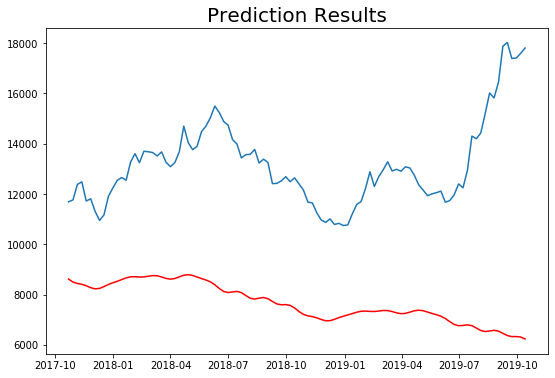

In [174]:
plt.plot(results['original_y'])
plt.plot(results['unlogged_scaled_yhat'], color='red')
plt.title("Prediction Results", fontsize=20)
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()

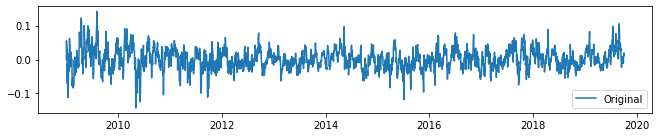

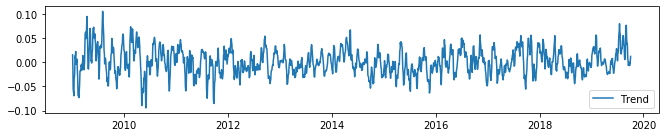

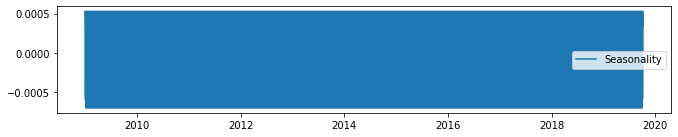

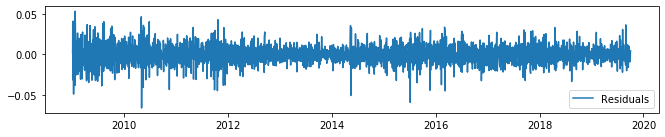

In [186]:
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(exdiff)
#fig = decomposition.plot()
#plt.show()

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(exdiff, label='Original')
plt.legend(loc='best')
plt.show()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.show()

plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.show()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [187]:
exdiff.to_csv('exdiff_preprocessed.csv', index=True, header=True)

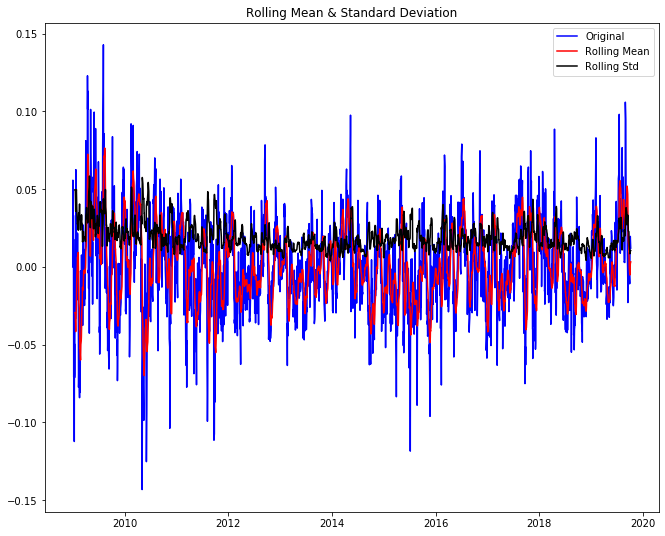

Results of Dickey-Fuller Test:
Test Statistic                -1.621079e+01
p-value                        3.988426e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.807000e+03
Critical Value (1%)           -3.432682e+00
Critical Value (5%)           -2.862570e+00
Critical Value (10%)          -2.567318e+00
dtype: float64


In [66]:
df = pd.read_csv('exdiff_preprocessed.csv')
df.index = df['Unnamed: 1']
df = df.iloc[:, 1:]
df.head()

df = df['Cash Price ($/MT)'].squeeze()
df.index = pd.to_datetime(df.index)
test_stationarity(df)

# Modeling

https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

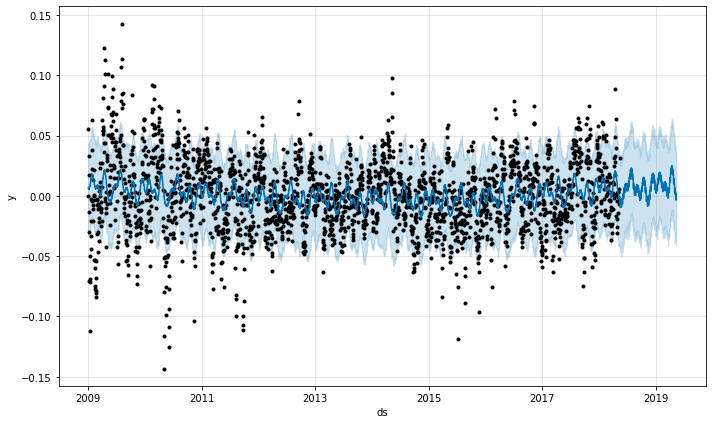

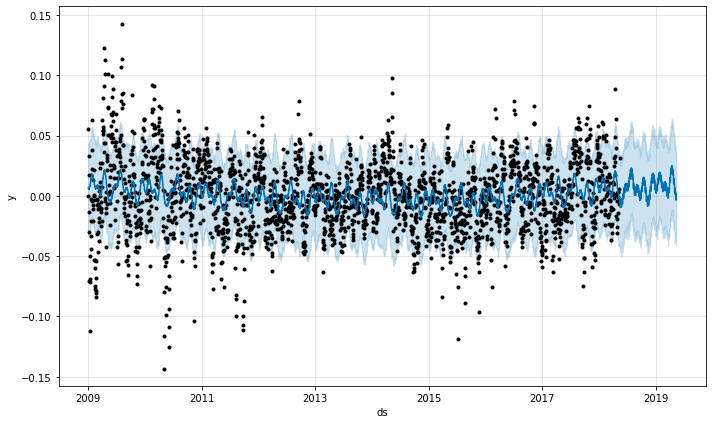

In [88]:
m.plot(forecast)

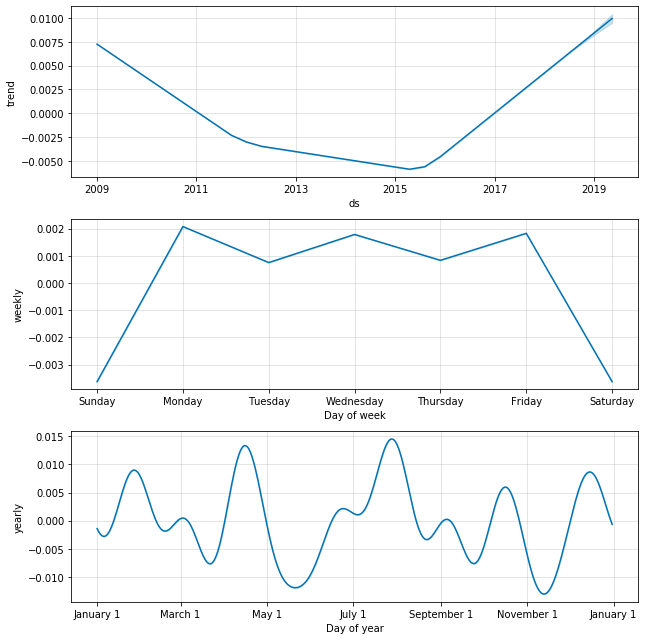

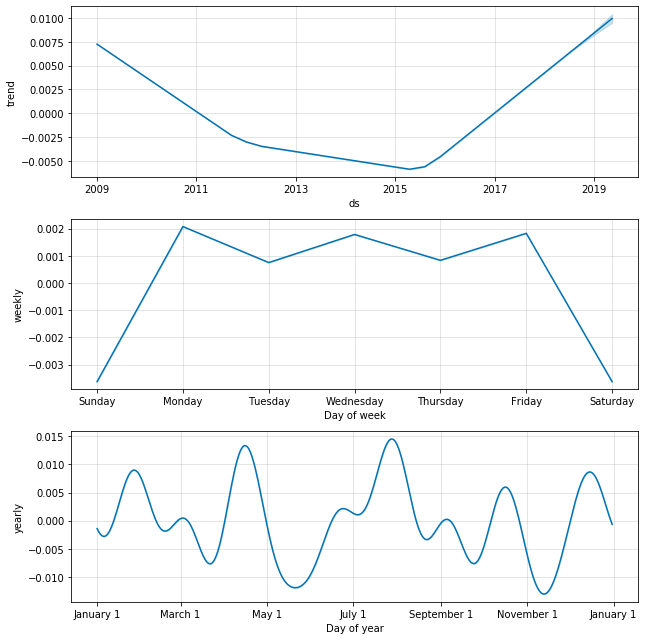

In [89]:
m.plot_components(forecast)

In [42]:
'''Joins predicted values with actual values'''
def make_comparison_dataframe(historical, forecast):
    
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# Creating comparison dataframe
cmp_df = make_comparison_dataframe(df, forecast)



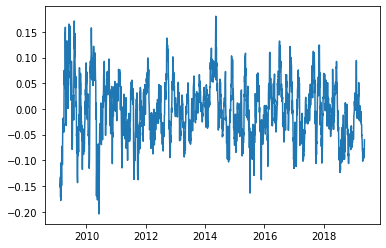

In [49]:
cmp_df['error'] =  cmp_df['y'] - cmp_df['yhat']
cmp_df.head()
plt.plot(cmp_df['error'])

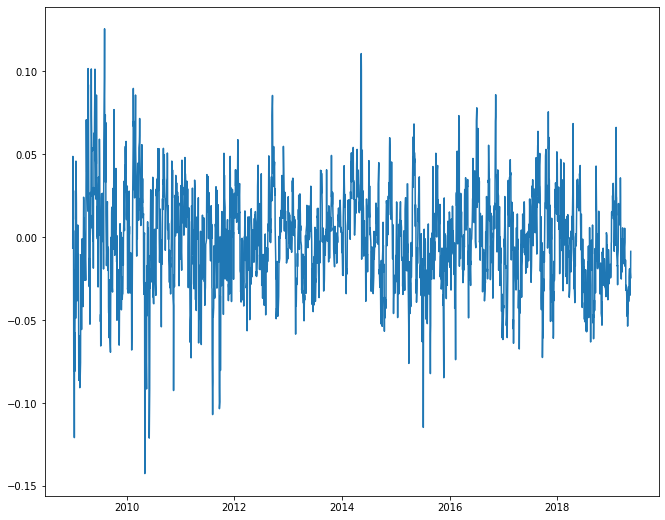

In [151]:
plt.plot(cmp_df['error'])

In [51]:
cmp_df = cmp_df.dropna()

def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    df['error'] = df['y'] - df['yhat']
    df['percentage'] = 100*df['error']/df['y']
    
    
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    print(predicted_part.head())
    return {'MAPE': error_mean('percentage'), 'MAE': error_mean('error')}

for err_name, err_value in calculate_forecast_errors(cmp_df.dropna(), prediction_size).items():
    print(err_name, err_value)

                yhat  yhat_lower  yhat_upper         y     error  percentage
ds                                                                          
2017-12-20  0.030911   -0.038317    0.101200  0.042610  0.011699   27.455771
2017-12-21  0.030106   -0.045255    0.099914  0.046177  0.016070   34.801897
2017-12-22  0.030545   -0.037697    0.100828  0.051237  0.020692   40.384256
2017-12-25  0.029742   -0.038494    0.100844  0.052215  0.022473   43.039938
2017-12-26  0.027537   -0.041608    0.098748  0.051225  0.023688   46.242715
MAPE 570.8182329084178
MAE 0.04271461087194927


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [46]:
np.sqrt(9)

3.0

In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725


In [97]:
pd.DataFrame({'mean':tester.rolling(window=3).mean(), 'original': tester})

,mean,original
0,NaN,1.0
1,NaN,2.0
2,2.000000,3.0
3,3.000000,4.0
4,6.000000,11.0
5,7.000000,6.0
6,8.000000,7.0
7,7.000000,8.0
8,8.000000,9.0
9,5.833333,0.5
